# Randomized measurements

This tutorial shows the different randomized measurements of the `povm_toolbox`.

In [1]:
%load_ext autoreload
%autoreload 2

## Circuit and Observables

We first look at a random the 2-qubit circuit, with depth 3.

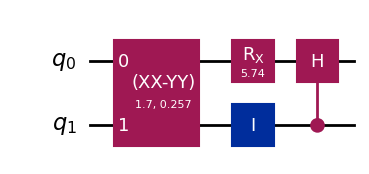

In [2]:
from qiskit.circuit.random import random_circuit

n_qubit = 2
qc_random = random_circuit(num_qubits=n_qubit, depth = 3, measure=False, seed=0)
qc_random.draw("mpl")

We also draw 3 random observables.

In [3]:
from qiskit.quantum_info import SparsePauliOp

set_observables = [
    SparsePauliOp(["II", "XX", "YY", "ZY"], coeffs=[1, 1, -4, 1]),
    SparsePauliOp(["XI", "ZX", "YI"], coeffs=[1, -1, 2.5]),
    SparsePauliOp(["II", "XI", "ZI", "IX", "IY", "YX"], coeffs=[0.4, 4, -1, 1, -0.5, 1.8]),
    ]

For reference, we compute the true final state and the exact expectation values for the different observables.

In [4]:
import numpy as np
from qiskit.quantum_info import Statevector

exact_state = Statevector(qc_random)
exp_val = np.real_if_close(np.array([exact_state.expectation_value(obs) for obs in set_observables]))

## Classical Shadows

We now look at the implementation of Classical Shadows measurement.

In [5]:
from povm_toolbox.library import ClassicalShadows

# By default, the Classical Shadows (CS) measurement uses X,Y,Z measurements with equal probability.
cs_implementation = ClassicalShadows(n_qubit=n_qubit)
# Define the default shot budget.
cs_shots = 4096
# Construct the `POVMSamplerPub`.
cs_pub = (qc_random, None, cs_shots, cs_implementation)

## Locally-Biased Classical Shadows
We now look at Classical Shadows that can be locally-biased.

In [6]:
from povm_toolbox.library import LocallyBiasedClassicalShadows

# Set the distributions of the shots among the X,Y,Z measurements.
bias = np.array([
    [0.0000000028, 0.4408677642, 0.5591322330], # bias for first qubit
    [0.1989721524, 0.3190601952, 0.4819676524], # bias for second qubit
    ])

# The Locally-Biased Classical Shadows (LBCS) measurement uses X,Y,Z measurements with different probabilities.
lbcs_implementation = LocallyBiasedClassicalShadows(n_qubit=n_qubit, bias=bias)
# Define the default shot budget.
lbcs_shots = 4096
# Construct the `POVMSamplerPub`.
lbcs_pub = (qc_random, None, lbcs_shots, lbcs_implementation)

## PM-simulable POVM
We now look at POVM that are simulable (through randomization) with only single-qubit projective measurements (PMs).

In [7]:
from povm_toolbox.library import RandomizedProjectiveMeasurements

# Define our projective measurements acting on each qubit.
angles = np.array([
    [0.0000027222, 0.0000000910, 1.5707688831, 0.0000235665, 1.5707519773, 1.5707694998],
    [0.0000022917, 0.0000002655, 1.5707961328, 0.0000069500, 1.5707958682, 1.5708006931],
    ])

# Set the distributions of the shots among the PMs.
bias = np.array([
    [0.0000372719, 0.4377084332, 0.5622542949],
    [0.2002136793, 0.3192036469, 0.4805826738],
    ])

# Define the PM-simulable POVM.
pmsim_implementation = RandomizedProjectiveMeasurements(n_qubit=n_qubit, bias=bias, angles=angles)
# Define the default shot budget.
pmsim_shots = 4100
# Construct the `POVMSamplerPub`.
pmsim_pub = (qc_random, None, pmsim_shots, pmsim_implementation)

## POVM Sampler

We now instantiate the `POVMSampler` that will use the different POVM measurements.

In [8]:
from povm_toolbox.sampler.povm_sampler import POVMSampler
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import Session

# Run the sampler job locally using AerSimulator.
backend = AerSimulator()
with Session(backend=backend) as session:
    # First define a standard sampler (that will be used under the hood).
    runtime_sampler = Sampler(session=session)
    # Then define the POVM sampler, which takes BaseSampler as an argument.
    povm_sampler = POVMSampler(runtime_sampler)
    # Submit the job by specifying which POVM to use, which circuit(s) to measure and the shot budget.
    job = povm_sampler.run([cs_pub, lbcs_pub, pmsim_pub])

/Users/dao/Documents/Internship/povm-toolbox/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


### Results
We retrieve the result object, which contains the POVM used and from which we can query the counts of each outcome.

In [9]:
from povm_toolbox.post_processor.povm_post_processor import POVMPostProcessor

# Retrieve the `PrimitiveResult` object, which contains 3 `POVMPubResult` objects.
result = job.result()
print(f'\n{"-":-<85}-\n')

# Loop through the different PUB results
for k, pub_result in enumerate(result):
    # Instantiate the post-processor from the PUB result.
    post_processor = POVMPostProcessor(pub_result)
    print(f'PUB number : {k}')
    # If one wants to explicitly retrieve the POVM used for a specific PUB,
    # it can be accessed through the metadata of the PUB result.
    print(f"POVM class:  {type(pub_result.metadata.povm_implementation)}")
    print(f"Number of shots : {sum(post_processor.counts[0].values())}\n")

    print('   Exact         CS estimate    Error      Estimated std     z-score')
    for i, obs in enumerate(set_observables):
        cs_est_exp_val, std = post_processor.get_single_exp_value_and_std(obs)
        print(f'   {np.real(exp_val[i]):>10.3e}   {cs_est_exp_val:>12.3e}   {abs(cs_est_exp_val-np.real(exp_val[i]))/abs(np.real(exp_val[i])):>8.1%}', end=" ")
        print(f'        {std:> 8.5f} {(cs_est_exp_val-np.real(exp_val[i]))/std:> 11.2f}')
    print(f'\n{"-":-<85}-\n')


--------------------------------------------------------------------------------------

PUB number : 0
POVM class:  <class 'povm_toolbox.library.classical_shadows.ClassicalShadows'>
Number of shots : 4096

   Exact         CS estimate    Error      Estimated std     z-score
    1.483e+00      1.196e+00      19.4%          0.19362       -1.48
   -1.411e+00     -1.341e+00       5.0%          0.08283        0.85
    2.955e+00      3.104e+00       5.0%          0.12764        1.17

--------------------------------------------------------------------------------------

PUB number : 1
POVM class:  <class 'povm_toolbox.library.locally_biased_classical_shadows.LocallyBiasedClassicalShadows'>
Number of shots : 4096

   Exact         CS estimate    Error      Estimated std     z-score
    1.483e+00      1.394e+00       6.0%          0.13476       -0.66
   -1.411e+00     -1.491e+00       5.6%          0.07941       -1.00
    2.955e+00      2.970e+00       0.5%          0.11651        0.13

-----